# Methodology

**1. Load and Preprocess Data**


*   Read images from Golden Images (Non-Defected,folder 1) for training.
*   Resize images to a fixed size (e.g., 256x256) for efficient training.
*   Normalize pixel values to [0,1].
*   Perform data augemenation

**2. Build a CNN Autoencoder**


*   **Encoder**: Compress image features.
*   **LDecoder**: Reconstruct the input image.
*   **Loss**: Mean Squared Error (MSE) to measure reconstruction quality.

**3. Train the Model**
* Train only on Golden Images to learn normal PCB patterns and validate with the defected images.
* Use Adam optimizer and early stopping for efficiency.

**4. Detect and locate Anomalies**
* Generate anomaly maps : High error → Anomalous region.


# 0. Set up and import libraries

In [ ]:
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator


# 1. Load and Preprocess Data

In [ ]:
# Set dataset paths
DATASET_PATH = "/content/drive/MyDrive/data"
GOLDEN_IMAGES_PATH = "Golden images"
DEFECTIVE_FOLDERS = ["pcb1_defect_images"]
HIGHLIGHTED_FOLDERS = ["pcb1_defect_highlighted", "pcb2_defect_highlighted", "pcb3_defect_highlighted"]


In [ ]:
def load_and_preprocess_image(image_path, target_size=(256, 256)):
    """ Load and preprocess an image for Autoencoder."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, target_size)  # Resize to match Autoencoder input
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    image = image.astype('float32') / 255.0  # Normalize to [0,1]
    return image

In [ ]:
# Load the dataset

def load_images_from_folder(dataset_path, folders, img_size=(256, 256)):
    images = []

    # Check if the input is a string (single folder) or a list of strings (multiple folders)
    if isinstance(folders, str):
        folders = [folders]  # Convert to list if a single folder is given

    # Loop through all folders in the list
    for folder in folders:
        folder_path = os.path.join(dataset_path, folder)  # Concatenate dataset_path with folder name
        if not os.path.exists(folder_path):
            print(f"Warning: Folder '{folder_path}' does not exist!")
            continue

        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            if os.path.isfile(img_path):  # Check if it's a file
                # Apply preprocessing step
                image = load_and_preprocess_image(img_path, target_size=img_size)
                images.append(image)

    return np.array(images)

In [ ]:
# Load normal and defected PCB images
IMG_SIZE = (256, 256)  # Height, Width
normal_pcb = load_images_from_folder(dataset_path=DATASET_PATH, folders=GOLDEN_IMAGES_PATH, img_size=IMG_SIZE)
defected_pcb = load_images_from_folder(dataset_path=DATASET_PATH, folders=DEFECTIVE_FOLDERS, img_size=IMG_SIZE)


In [ ]:
len(normal_pcb)

10

In [ ]:
len(defected_pcb)

6

# 3. Data Augmentation

In [ ]:
# Data augmentation pipeline for PCB anomaly detection
data_augmentation = tf.keras.Sequential([
    RandomRotation(factor=0.1),            # Apply rotations up to 10%
    RandomTranslation(height_factor=0.1, width_factor=0.1),  # Apply random translations (shift)
    RandomFlip("horizontal_and_vertical") # Flip both horizontally and vertically
])

In [ ]:
def apply_augmentation_to_images(images):
    # Ensure images have shape (batch_size, height, width, channels)
    augmented_images = []

    for image in images:
        image = np.expand_dims(image, axis=-1)  # Add channel dimension (for grayscale images)
        image = np.expand_dims(image, axis=0)  # Add batch dimension

        # Apply augmentation
        augmented_image = data_augmentation(image, training=True)

        # Remove the batch dimension after augmentation and append the result
        augmented_images.append(np.squeeze(augmented_image, axis=0))  # Remove the batch dimension

    return np.array(augmented_images)

In [ ]:
# Apply data augmentation to the normal images
augmented_normal_pcb = apply_augmentation_to_images(normal_pcb)

# 3. Build the Autoencoder

In [ ]:
def build_autoencoder(input_shape=(256, 256, 1)):
    """ Create an Autoencoder for anomaly detection."""
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

In [ ]:
# Initialize Autoencoder
autoencoder = build_autoencoder()

# 4. Train the Autoencoder

In [ ]:
# Callbacks for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Train model using augmented normal images for training and defected images for validation (no augmentation)

history = autoencoder.fit(
    np.array(augmented_normal_pcb), np.array(augmented_normal_pcb),  # Augmented normal images as both input and target
    epochs=20,
    batch_size=1,
    shuffle=True,
    validation_data=(np.array(defected_pcb), np.array(defected_pcb)),  # No augmentation on validation data
    callbacks=[early_stopping]
)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - loss: 0.0176 - val_loss: 0.0505
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - loss: 0.0156 - val_loss: 0.0519
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - loss: 0.0148 - val_loss: 0.0543
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.0139 - val_loss: 0.0491
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 0.0129 - val_loss: 0.0450
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - loss: 0.0116 - val_loss: 0.0407
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 0.0120 - val_loss: 0.0455
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - loss: 0.0115 - val_loss: 0.0431
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.0109 - val_loss: 0.0413
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 0.0108 - val_loss: 0.0391
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.0107 - val_loss: 0.0385
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step

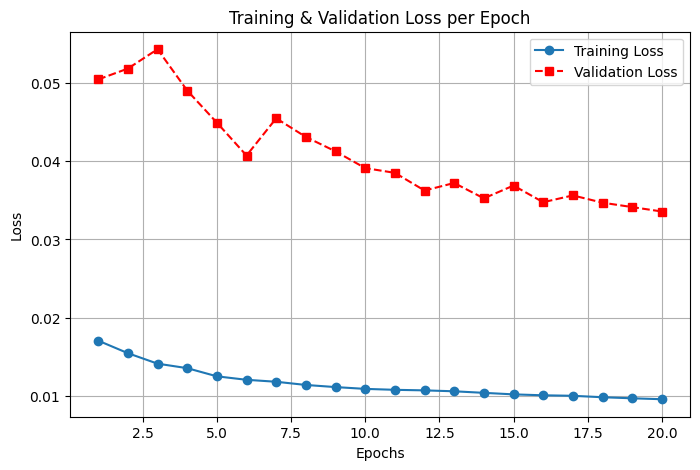

In [ ]:
# Extract loss values per epoch
train_losses = history.history['loss']
val_losses = history.history['val_loss']

# Save losses to JSON file
losses = {"training_loss": train_losses, "validation_loss": val_losses}
with open("losses.json", "w") as f:
    json.dump(losses, f)

# Plot training and validation loss curves
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', linestyle='-', label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='s', linestyle='--', label="Validation Loss", color='red')

# Labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss per Epoch")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# 5. Evaluate and Generate Anomaly Ma

In [ ]:
# Example paths
normal_pcb_path = "/content/drive/MyDrive/data/Golden images/golden_image_1.png"
defected_pcb_path = "/content/drive/MyDrive/data/pcb1_defect_images/defect_image_1.png"

In [ ]:
# Load images
golden_img = cv2.imread(normal_pcb_path, cv2.IMREAD_GRAYSCALE)
defected_img = cv2.imread(defected_pcb_path, cv2.IMREAD_GRAYSCALE)

In [ ]:
# Resize images for model compatibility
IMG_SIZE = 256
golden_img = cv2.resize(golden_img, (IMG_SIZE, IMG_SIZE)) / 255.0
defected_img = cv2.resize(defected_img, (IMG_SIZE, IMG_SIZE)) / 255.0
defected_img = defected_img.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [ ]:
# Predict using Autoencoder
reconstructed = autoencoder.predict(defected_img)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


MSE: 0.0340284740146454


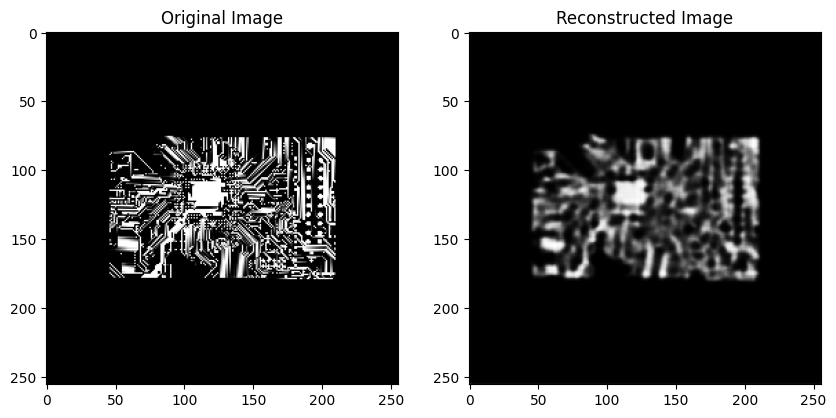

In [ ]:
def calculate_mse(original, reconstructed):
    return np.mean((original - reconstructed) ** 2)



# Calculate MSE and SSIM
mse = calculate_mse(defected_img[0], reconstructed)
print(f"MSE: {mse}")

# Visualize the original and reconstructed images
def visualize_reconstruction(original, reconstructed):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original.squeeze(), cmap='gray')
    axes[0].set_title('Original Image')
    axes[1].imshow(reconstructed.squeeze(), cmap='gray')
    axes[1].set_title('Reconstructed Image')
    plt.show()

# Example usage
visualize_reconstruction(defected_img[0], reconstructed)

In [ ]:
# Generate Anomaly Heatmap
def generate_anomaly_map(original, reconstructed):
    """ Generate anomaly heatmap based on reconstruction error."""
    error_map = np.abs(original - reconstructed)
    heatmap = (error_map - np.min(error_map)) / (np.max(error_map) - np.min(error_map))
    return heatmap

In [ ]:
anomaly_map = generate_anomaly_map(np.squeeze(defected_img), reconstructed.squeeze())

In [ ]:
defected_img = np.squeeze(defected_img)

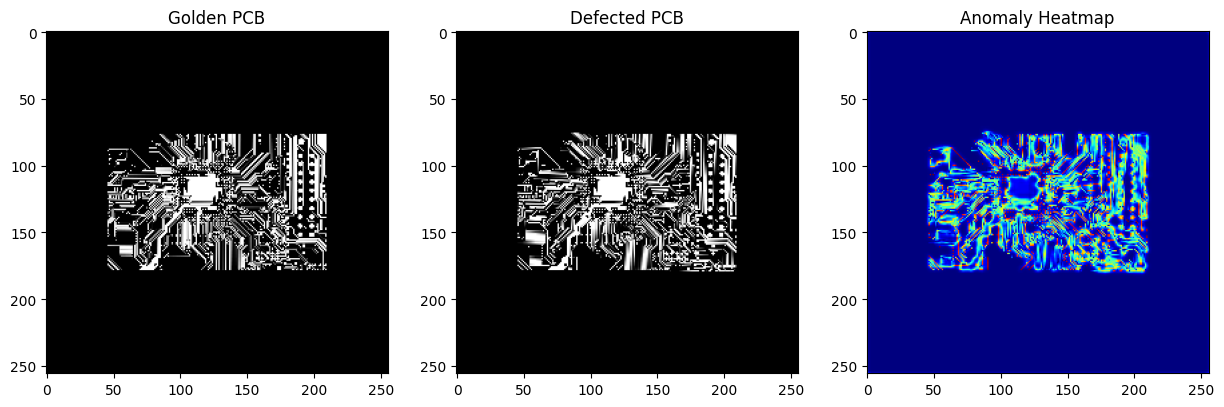

In [ ]:
# Display Results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(golden_img, cmap='gray'); ax[0].set_title('Golden PCB')
ax[1].imshow(defected_img, cmap='gray'); ax[1].set_title('Defected PCB')
ax[2].imshow(anomaly_map, cmap='jet'); ax[2].set_title('Anomaly Heatmap')
plt.show()